In [1]:
#I am also doing the probabilist machine learning course, so I will use torch for learning reason instead of numpy
import torch
import numpy as np
from scipy.optimize import minimize,LinearConstraint
import matplotlib.pyplot as plt
import networkx as nx
from IPython.display import Image, display
from scipy.sparse.csgraph import connected_components
import random
import math
np.random.seed(10)# add here the libraries you need

# Discrete Time Markov Chains - Part 2
This is an exercise notebook on DTMCs. 

Remember to revise of the lecture on DTMC simulation before attempting to solve it!
In order to complete this notebook, you need the models implemented in Part 1 notebook on DTMC.

In [2]:
#Rewritten using torch
def transient_probability(transition_model, probability_init_model,n):
    probability_init_model=probability_init_model.reshape(1,probability_init_model.size(dim=0))
    temp=torch.mm(probability_init_model,torch.matrix_power(transition_model, n))
    return temp.reshape(temp.size(dim=1))


### 1. Simulation of DTMC
Write a method that simulates a DTMC for `n` steps, where `n` is a parameter of the method, and returns the whole trajectory as output.

In [3]:
def sampling(dist):
    u=torch.rand(1)
    s=0
    for i in range(len(dist)):
        s=s+dist[i]
        if u<=s:
            return i


def simulate(A,b,n):
    X=torch.zeros(n,dtype=torch.int64)
    p=b
    X[0]=sampling(p)
    for i in range(1,n):
        p=A[X[i-1],:]
        X[i]=sampling(p)
    
    return X.tolist()


    

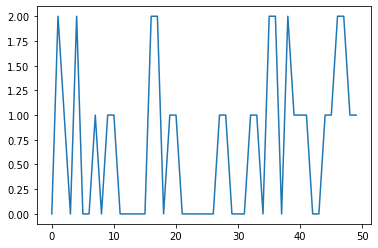

In [4]:
test=torch.zeros([3,3])
test[0,0]=0.5
test[0,1]=0.3
test[0,2]=0.2
test[1,0]=0.4
test[1,1]=0.5
test[1,2]=0.1
test[2,0]=0.3
test[2,1]=0.3
test[2,2]=0.4
initprob=torch.tensor([0.4,0.3,0.3])
X=simulate(test,initprob,50)
plt.plot([i for i in range(50)],X)


### 2. Statistical analysis
Write methods for:
- 2.1. computing the average of a function `f` of the state space, at time step `n`.
- 2.2. computing the probability of reaching a target region `A` of the state space by time step `n`.

Both methods should use simulation, and return an estimate and a confidence interval at a specified confidence level `alpha` (0.95% by default).

In [5]:
def average(f,matrix,b,n):
    m=10000
    w=torch.zeros(m)
    p=transient_probability(matrix,b,n)
    for i in range(m):
        temp=sampling(p)
        w[i]=f(temp)
    mean=torch.mean(w).item()
    std=torch.std(w,unbiased=False).item() #no correction for covariance is used
    return (mean,mean-1.96*std/math.sqrt(m),mean+1.96*std/math.sqrt(m))

print(average(lambda x: x**2 ,test,initprob,10))        


(1.21589994430542, [-1.2041500139875034, 3.6359499025983433])


In [67]:
def reach_prob(matrix,b,n,A):
    m=10000
    w=torch.zeros(m)
    pos=torch.tensor(0,dtype=torch.float64)
    for i in range(m):
        x=torch.tensor(simulate(matrix,b,n))
        w[i]=(sum([torch.sum(x==A[i]) for i in range(len(A))])>0)
    mean=torch.mean(w).item()
    std=torch.std(w,unbiased=False).item() #no correction for covariance is used
    return (mean,mean-1.96*std/math.sqrt(m),mean+1.96*std/math.sqrt(m))
        
print(reach_prob(test,initprob,2,[1,2]))

(0.7980999946594238, 0.7902322024345398, 0.8059677868843078)


### 3. Branching chain
Consider a population, in which each individual at each
generation independently gives birth to $k$ individuals with
probability $p_k$. These will be the members of the next
generation. Assume $k\in\{-1, 0,1,2\}$. The population is initial compused of two individuals Adam and Eve.

Assume now that $p_0 = p_1 = p_2 = (1-p_{-1})/3$. Estimate the average and the confidence interval of the probability of the population to become extinct for increasing values of $p_{-1}$.

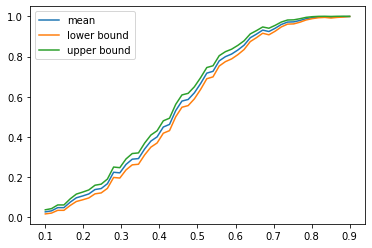

In [70]:
def extinction(p):
    prob=torch.tensor([p,(1-p)/3,(1-p)/3,(1-p)/3])
    m=1000
    w=torch.zeros(m)
    for i in range(m):
        nold=2
        for j in range(5):
            n=0
            for k in range(nold):
                temp=sampling(prob)
                n=n+temp
            nold=n
        w[i]=(nold==0)
    mean=torch.mean(w).item()
    std=torch.std(w,unbiased=False).item() #no correction for covariance is used
    return (mean,mean-1.96*std/math.sqrt(m),mean+1.96*std/math.sqrt(m))

vecprob=torch.linspace(0.1,0.9,50).tolist()
vecextmean=torch.zeros(50).tolist()
vecextup=torch.zeros(50).tolist()
vecextdown=torch.zeros(50).tolist()

for i in range(50):
    temp=extinction(vecprob[i])
    vecextmean[i]=temp[0]
    vecextdown[i]=temp[1]
    vecextup[i]=temp[2]

    
plt.plot(vecprob,vecextmean,label="mean")
plt.plot(vecprob,vecextdown,label="lower bound")
plt.plot(vecprob,vecextup,label="upper bound")
plt.legend()
plt.show()
